In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import localtime, strftime
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.options.display.float_format = '{:.2f}'.format
plt.rc('font', family='gulim')

In [11]:
df = pd.read_csv("해보자.csv",encoding='euc=kr')
df

,일자,도매가격.원.kg.,생산량..톤.,10a당.생산량.톤,평균기온..C.,일강수량.mm.,평균.풍속.m.s.,합계.일조시간.hr.,평균.지면온도..C.,평균.5cm.지중온도..C.
0,2015-07-11,5833,2385,0.78,19.66,6.98,1.67,6.38,21.77,22.15
1,2015-07-10,6875,2385,0.78,19.64,6.98,1.66,6.39,21.73,22.12
2,2015-08-06,10000,2385,0.78,19.21,7.31,1.57,6.32,21.66,22.07
3,2015-09-21,3125,2385,0.78,15.55,7.44,1.48,4.77,17.20,17.89
4,2016-07-02,2500,1452,0.81,20.03,11.76,1.43,6.05,23.00,22.61
...,...,...,...,...,...,...,...,...,...,...
1347,2020-09-03,5500,2476,1.05,17.06,12.38,1.55,4.67,20.30,19.74
1348,2020-07-31,5300,2476,1.05,19.15,11.90,1.54,4.94,22.67,21.89
1349,2020-08-07,4900,2476,1.05,18.76,12.02,1.55,4.94,22.27,21.54
1350,2020-06-01,5245,2476,1.05,16.78,10.51,1.86,5.80,19.97,19.06


In [12]:
df.일자 = pd.to_datetime(df.일자)
df = df.set_index('일자')

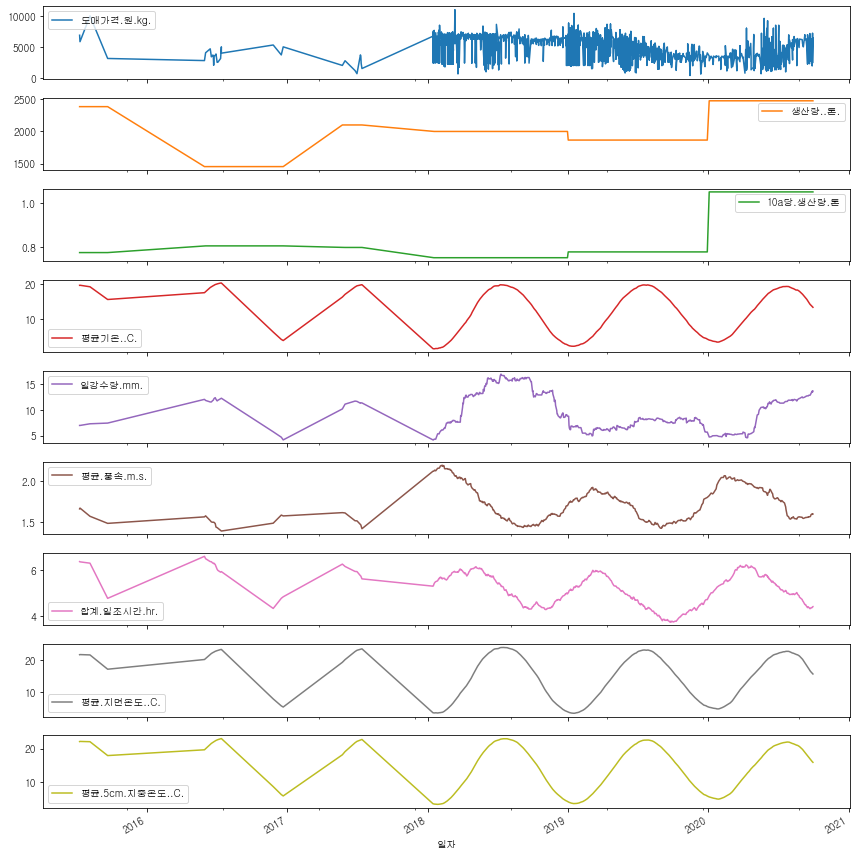

In [13]:
df.plot(subplots=True, figsize=(12,12))
plt.tight_layout()
plt.show()

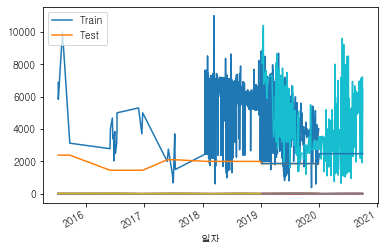

In [14]:
train = df.iloc[:946]
test = df.iloc[-406:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_sd = scaler.fit_transform(train)
test_sd = scaler.fit_transform(test)

In [22]:
train_sd = pd.DataFrame(train_sd, columns=train.columns, index=train.index)
test_sd = pd.DataFrame(test_sd, columns=test.columns, index=test.index)

print(train_sd.shape, test_sd.shape)


(946, 9) (406, 9)


In [23]:
X_train1 = train_sd.drop(['도매가격.원.kg.'], axis=1)
y_train1 = train_sd[['도매가격.원.kg.']]
X_test1 = test_sd.drop(['도매가격.원.kg.'], axis=1)
y_test1 = test_sd[['도매가격.원.kg.']]

In [24]:
X_train = X_train1.values
y_train = y_train1.values
X_test = X_test1.values
y_test = y_test1.values

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [26]:
# LSTM을 돌리기 위해 3차원으로 reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_test.shape, y_train.shape)

(946, 8, 1) (406, 8, 1) (946, 1)


In [27]:
# LSTM model 구축 (50개의 뉴런층)
# activation : 활성화 함수(렐루함수 : 은닉층에 주로 활용되는 함수)
# Dense의 1은 총 출력 뉴런이 1개라는 뜻
#return_sequences=True, 
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [30]:
# train model 
# epochs : 총 훈련 횟수 (epochs를 높게하면 정확도가 올라간다)
# batch_size : 한 번 훈련할 때 입력되는 데이터 크기
# verbose : 학습 중 과정을 출력하는지 안 하는 지

model_fit = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0,
                      validation_data=(X_test, y_test))

In [31]:
# 테스트 데이터를 통해 학습한 모델에 대한 정확도를 평가
loss, mse = model.evaluate(X_test, y_test, batch_size=32)
print(loss, mse)


13/13 [==============================] - 0s 2ms/step - loss: 0.0696 - mse: 0.0696
0.069615438580513 0.069615438580513


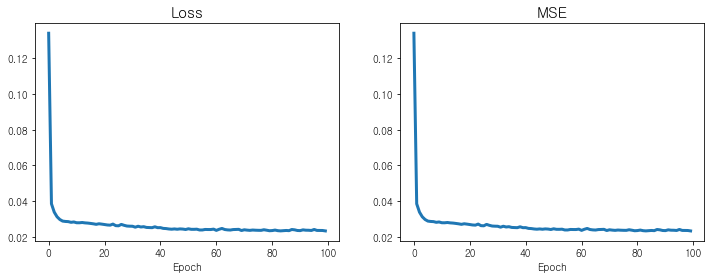

In [32]:
hist = model_fit.history
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=10)

ax = fig.add_subplot(1,2,2)
ax.plot(hist['mse'], lw=3)
ax.set_title('MSE', size=15)
ax.set_xlabel('Epoch', size=10)
plt.show()

In [35]:
y_pred = model.predict(X_test, batch_size=1)
y_pred.shape

(406, 1)

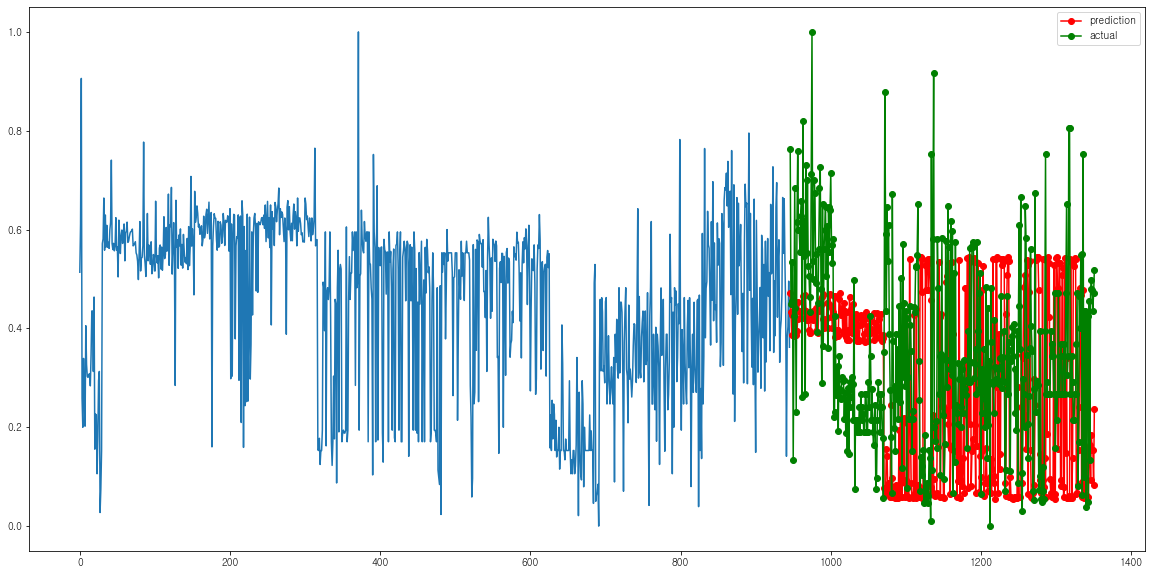

In [38]:
# 시각화
a_axis = np.arange(0,len(y_train))
b_axis = np.arange(len(y_train),len(y_train)+len(y_pred))

plt.figure(figsize=(20,10))
plt.plot(a_axis, y_train.reshape(946,),'-')
plt.plot(b_axis, y_pred.reshape(406,),'o-r',label='prediction')
plt.plot(b_axis, y_test.reshape(406,),'o-g',label='actual')
plt.legend()
plt.show()

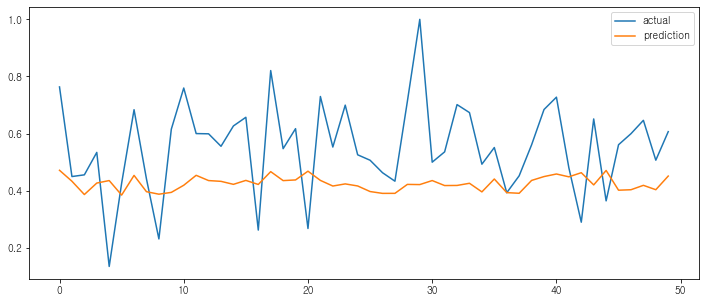

In [39]:
# 실제값과 예측값 50개 비교
plt.figure(figsize=(12, 5))
plt.plot(y_test[0:50], label = 'actual')
plt.plot(y_pred[0:50], label = 'prediction')
plt.legend()
plt.show()

In [40]:
y_pred = model.predict(X_test, batch_size=1)
y_pred.shape

(406, 1)

In [41]:
X_test.shape

(406, 8, 1)

In [42]:
from sklearn.metrics import mean_squared_error

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# invert scaling for forecast
inv_y_pred = np.concatenate((y_pred, X_test), axis=1)
inv_y_pred = scaler.inverse_transform(inv_y_pred)
inv_y_pred = inv_y_pred[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
rmse

2573.303673567495

In [44]:
y_test_df = pd.DataFrame(y_test, columns=['actual_price'])
y_pred_df = pd.DataFrame(y_pred, columns=['garlic_prediction'])

result = y_test_df.join(y_pred_df)
result = result.set_index(y_test1.index)
result.head()

,actual_price,garlic_prediction
일자,,
2019-04-08,0.76,0.47
2019-05-27,0.45,0.43
2019-08-26,0.46,0.39
2019-06-11,0.53,0.43
2019-05-25,0.13,0.44


In [45]:
result.to_csv("garlic_LSTM.csv", index = True, encoding='euc-kr')